In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from src.data_gen import data_gen, data_gen_xu

# Set the global font to be Times New Roman
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 8 
colors = sns.color_palette()
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

### 1. Data generating process of this paper

\begin{equation}
y_{it} = d_{it} \circ \delta_{it} + (X'_{it}\Gamma) F_{t} + X'_{it}\beta + \alpha_i + \xi_t + \epsilon_{it}.
\end{equation}

+ $y_{it}$ is a scaler of outcome.

+ Total number of units $N=N_{co} + N_{tr}$.

+ Total number of time periods $T=T_0 + T_1$.

+ $d_{it}$ indicates units with or without treatment

+ $\delta_{it}$ indicates treatment effect, which is heterogenous (across units and periods)

+ $X_{it}$ is a $L\times 1$ vector of observed covariates

+ $\Gamma$ is a $L\times K$ transforming matrix

+ $\Lambda_{it}$ is a $1 \times K$ vector of factor loadings

+ $F_t$ is a $K\times 1$ vector of unobserved common factors

In [2]:
def gen_stationary_AR1(n):
    """
    Generate a random n x n matrix A1 for a VAR(1) process
    that satisfies the stationarity condition (all eigenvalues lie inside the unit circle).
    """
    while True:
        # Generate a random matrix
        A1 = np.random.rand(n, n) - 0.5  # Shift to have negative and positive values
        # Check if the generated matrix satisfies the stationarity condition
        eigenvalues = np.linalg.eigvals(A1)
        if np.all(np.abs(eigenvalues) < 1):
            return A1

In [3]:
# Number of factors and time periods
K = 3
T0 = 20
T1 = 10
T = T0 + T1
# Number of total covariates
L = 10
# Number of control and treated units
N_co = 45
N_tr = 5
N = N_co + N_tr

# Generate factors following VAR(1) process
# Gen variance-covariance matrix
A1 = gen_stationary_AR1(K)
# Initial values for the first period are drawn from a uniform distribution
F = np.zeros((K, T))
F[:, 0] = np.random.uniform(-1, 1, size=K)
# Generate the time series
for t in range(1, T):
    F[:, t] = A1 @ F[:, t-1] + np.random.normal(0, 1, K)

# Generate the covariates following VAR(1) process
# Covariates of each unit follow their own VAR(1) process
# The correlation between the covariates is not assumed to be zero
A2 = np.zeros((N, L, L))
for i in range(N):
    A2[i] = gen_stationary_AR1(L)
# Initial values for the first period are drawn from a uniform distribution
X = np.zeros((N, T, L))
X[:, 0, :] = np.random.uniform(-1, 1, size=(N, L))
# Generate the time series for control units
for i in range(N_co):
    for t in range(1, T):
        X[i,t,:] = A2[i]@X[i,t-1,:] + np.random.normal(0, 1, L)
# Generate the time series for the treated units with a drift
drift = 2
for i in range(N_co, N):
    for t in range(1, T):
        X[i,t,:] = A2[i]@X[i,t-1,:] + np.random.normal(drift, 1, size=L)

# Generate Gama
Gama = np.random.uniform(-0.1, 0.1, size=(L, K))

# Generate coefficient beta, unit and time fixed effects
beta = np.random.uniform(0, 1, L)
alpha = np.random.uniform(0, 1, N)
xi = np.random.uniform(0, 1, T)

# Generate treatment effects and treatment assignment
d = np.concatenate([np.zeros(N_co), np.ones(N_tr)])
delta = np.concatenate([np.zeros(T0), np.arange(1, T1+1) + np.random.normal(0,1,T1)])

# Generate outcome
Y = np.zeros((N, T))
for i in range(N):
    for t in range(T):
        Y[i, t] += X[i,t,:] @ Gama @ F[:,t] # factors and instrumented factor loadings
        Y[i, t] += X[i,t,:] @ beta # linear effects from covariates
        Y[i, t] += alpha[i] + xi[t] # unit and time fixed effects
        Y[i, t] += d[i] * delta[t] # treatment effects
        Y[i, t] += np.random.normal() # noise 

# Construct dataframes
df = pd.DataFrame({
    'id': np.repeat(np.arange(101, 101+N), T),
    'time': np.tile(np.arange(1981, 1981+T), N),
    'y': Y.flatten(),
    'tr_group': np.repeat(d, T),
    'post_period': np.tile(np.arange(1, T+1)>T0, N),
    'eff': np.tile(delta, N)
})

# treatment indicator
df['d'] = df['tr_group'] * df['post_period']
# add covariates
for i in range(L):
    df['x'+str(i+1)] = X[:,:,i].flatten()

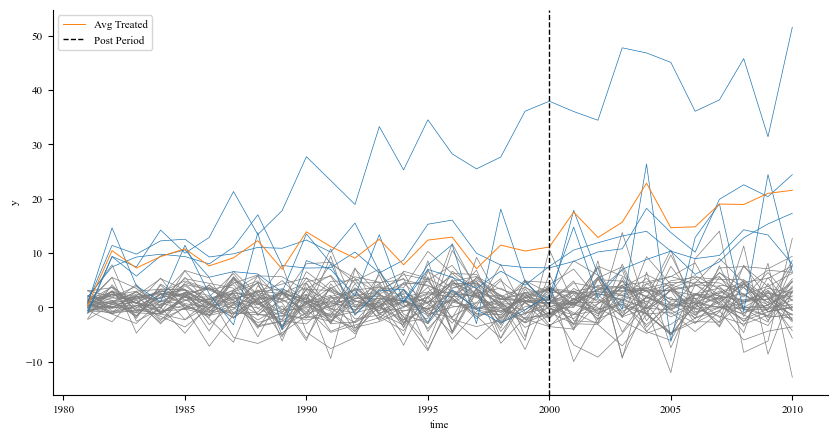

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(data=df.query("tr_group==0"), x='time', y='y', ax=ax, units='id', estimator=None, color=colors[7], linewidth=0.5)

sns.lineplot(data=df.query("tr_group==1"), x='time', y='y', ax=ax, units='id', estimator=None, color=colors[0], linewidth=0.5)

ax.plot(df.query("tr_group==1").groupby('time').y.mean(), color=colors[1], linewidth=0.7, label='Avg Treated')
ax.axvline(x=df.query("post_period==0").time.max(), color='black', linestyle='--', linewidth=1, label='Post Period')
ax.legend()

sns.despine()

### 1.2 Simple event study plot 

In [5]:
# create time dummy
dat = pd.concat([df, pd.get_dummies(df.time, prefix='year')], axis=1)

# starting year and end year
start = df.time.min()
end = df.time.max()
tr_year = df.query('post_period==0').time.max()

# drop the year 2000 (one year before the treatment)
formula ='y ~ 1 +' + ' + '.join([f'tr_group*year_{year}' for year in range(start, end+1) if year not in [tr_year]])

import statsmodels.api as sm
# fit OLS model 
fit = sm.OLS.from_formula(formula, data=dat).fit()

In [6]:
datt = pd.DataFrame(index=range(start, end+1), columns=['coef'])
datt['coef'] = np.concatenate([fit.params[31:50].values, np.array([0]), fit.params[50:].values])
datt['bse'] = np.concatenate([fit.bse[31:50].values, np.array([0]), fit.bse[50:].values])

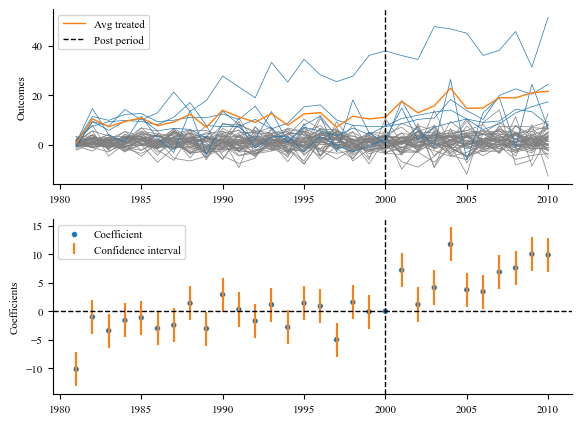

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(6.7, 5))

sns.lineplot(data=df.query("tr_group==0"), x='time', y='y', ax=ax[0], units='id', estimator=None, color=colors[7], linewidth=0.5)
sns.lineplot(data=df.query("tr_group==1"), x='time', y='y', ax=ax[0], units='id', estimator=None, color=colors[0], linewidth=0.5)
ax[0].plot(df.query("tr_group==1").groupby('time').y.mean(), color=colors[1], linewidth=1, label='Avg treated')
ax[0].axvline(x=df.query("post_period==0").time.max(), color='black', linestyle='--', linewidth=1, label='Post period')
ax[0].legend()
ax[0].set(xlabel='', ylabel='Outcomes')

ax[1].errorbar(x=datt.index, y='coef', yerr=[datt['bse'], datt['bse']], data=datt, fmt='none', color=colors[1], label='Confidence interval')
sns.scatterplot(x=datt.index, y='coef', data=datt, ax=ax[1], size=0.5, legend=False, label='Coefficient')
ax[1].axvline(x=tr_year, linestyle='--', color='black', linewidth=1)
ax[1].axhline(y=0, linestyle='--', color='black', linewidth=1)
ax[1].set(xlabel='', ylabel='Coefficients')
ax[1].legend()

sns.despine()
#plt.savefig('figs/data_plot.png', dpi=300)

### 2. Data generating process of Yiqing Xu


$$
Y_{it} = \delta_{it} \circ D_{it} + X_{it}\beta + \lambda_i' f_t + \alpha_i + \xi_t + \epsilon_{it}
$$

$$
x_{it,l} = 1 + \lambda'_i f_t + \sum_{k=1}^K\lambda_{ik} + \sum_{k=1}^Kf_{kt} + \eta_{it,l}
$$

In [9]:
# we continue to use the N, T, K defined before
# w: similarity between treated and control units, 1 means identical
w = 0.8

ss = np.sqrt(3)

# gen beta
beta = np.random.uniform(0, 1, L)
# gen noise
epsilon = np.random.normal(0, 1, size=(N, T))
# gen factor f
f = np.random.normal(0, 1, size=(K, T))
# gen time fixed effects xi
xi = np.random.normal(0, 1, T)

# gen factor loadings for control and treated units
lambda_co = np.random.uniform(-ss, ss, size=(K, N_co))
lambda_tr = np.random.uniform(ss-2*w*ss, 3*ss-2*w*ss, size=(K, N_tr))

# gen unit fixed effects for control and treated units
alpha_co = np.random.uniform(-ss, ss, size=N_co)
alpha_tr = np.random.uniform(ss-2*w*ss, 3*ss-2*w*ss, size=N_tr)

# combine factor loadings and unit fixed effects
lambda_ = np.concatenate([lambda_co, lambda_tr], axis=1)
alpha = np.concatenate([alpha_co, alpha_tr])

# gen treatment effects and assignment
d = np.concatenate([np.zeros(N_co), np.ones(N_tr)])
delta = np.concatenate([np.zeros(T0), np.arange(1, T1+1) + np.random.normal(0, 1, T1)])

# noise for covariates 
eta = np.random.normal(L, N, T)

# gen covariates
X = np.zeros((N, T, L))
for i in range(L):
    for k in range(K):
        X[:, :, i] = lambda_.T@f + lambda_[k].reshape(-1, 1) + f[k] + eta[i] + 1

# gen outcome
y = d.reshape(-1,1)@delta.reshape(1, -1) + X@beta + lambda_.T@f + alpha.reshape(-1,1) + xi + epsilon

# contruct the dataframe
df = pd.DataFrame({
    'id': np.repeat(np.arange(101, 101+N), T),
    'time': np.tile(np.arange(1981, 1981+T), N),
    'y': y.flatten(),
    'tr_group': np.repeat(d, T),
    'post_period': np.tile(np.arange(1, T+1)>T0, N),
    'eff': np.tile(delta, N)
})

# treatment indicator 
df['d'] = df['tr_group']*df['post_period']
# add covariates
for i in range(L):
    df['x'+str(i+1)] = X[:,:,i].flatten()


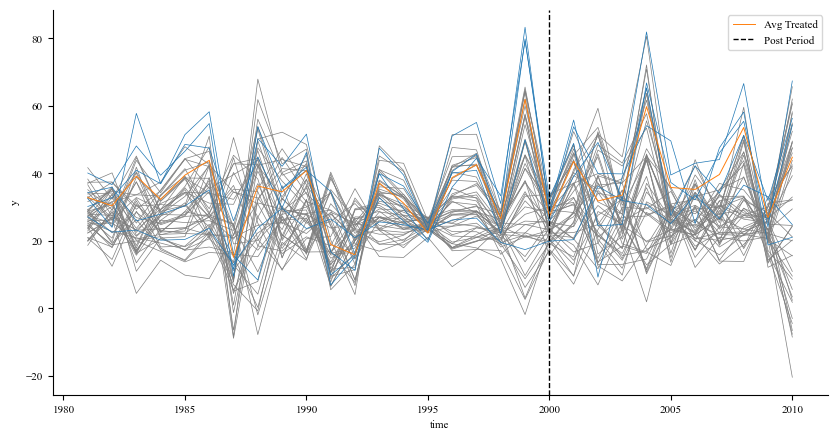

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(data=df.query("tr_group==0"), x='time', y='y', ax=ax, units='id', estimator=None, color=colors[7], linewidth=0.5)

sns.lineplot(data=df.query("tr_group==1"), x='time', y='y', ax=ax, units='id', estimator=None, color=colors[0], linewidth=0.5)

ax.plot(df.query("tr_group==1").groupby('time').y.mean(), color=colors[1], linewidth=0.7, label='Avg Treated')
ax.axvline(x=df.query("post_period==0").time.max(), color='black', linestyle='--', linewidth=1, label='Post Period')
ax.legend()

sns.despine()